## Masculinity Survey
#### Ideas about masculinity

masculinity-survey.csv contains the results of a survey of 1,615 adult men conducted by SurveyMonkey in partnership with FiveThirtyEight and WNYC Studios from May 10-22, 2018. 

https://github.com/fivethirtyeight/data/blob/master/masculinity-survey/masculinity-survey.pdf

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
pd.options.display.max_columns = 99

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [116]:
responses = pd.read_excel('masculinity-responses-renamed.xlsx')

In [5]:
responses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1615 entries, 1 to 1615
Data columns (total 97 columns):
StartDate                    1615 non-null datetime64[ns]
EndDate                      1615 non-null datetime64[ns]
self_manly                   1615 non-null object
others_manly                 1615 non-null object
source_ideas_father          1615 non-null object
source_ideas_mother          1615 non-null object
source_ideas_family          1615 non-null object
source_ideas_popculture      1615 non-null object
source_ideas_friends         1615 non-null object
source_ideas_other           1615 non-null object
societal_pressure            1615 non-null object
prof_advice                  1615 non-null object
personal_advice              1615 non-null object
phys_aff                     1615 non-null object
cry                          1615 non-null object
phys_fight                   1615 non-null object
sex_women                    1615 non-null object
sex_men                    

In [6]:
responses.shape

(1615, 97)

I am interested in using some of the demographic data and responses to predict self-reported sense of masculinity. I'll use reponses to this column:
>In general, how masculine or 'manly' do you feel?

In [7]:
responses['self_manly'].value_counts()

Somewhat masculine      826
Very masculine          612
Not very masculine      131
Not at all masculine     32
No answer                14
Name: self_manly, dtype: int64

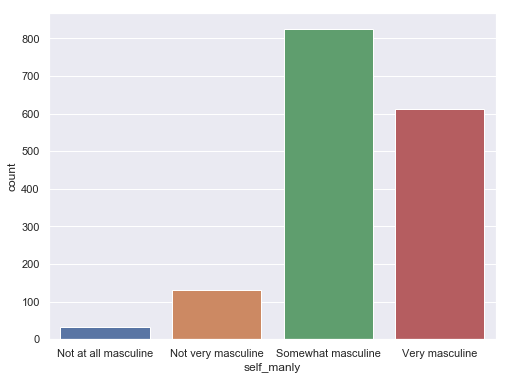

In [70]:
sns.set(style="darkgrid")
plt.figure(figsize=(8, 6))
ax = sns.countplot(x="self_manly", data=responses, order = ['Not at all masculine', 'Not very masculine', 'Somewhat masculine', 'Very masculine'])

In [117]:
responses = responses[responses.self_manly != 'No answer']

The response options were on a graded scale, from 'Not at all' to 'Very', so I decided to map to numeric values (0-3)

In [118]:
responses['self_manly'] = responses['self_manly'].map({'Not at all masculine':0, 
                                                       'Not very masculine':1, 
                                                       'Somewhat masculine':2,
                                                        'Very masculine': 3})

In addition to the demographic information, I was interested in using some of the responses to the survey questions. In particular, I was interested in the following questions:
<br>Which of the following do you worry about on a daily or near daily basis?
>Your height
<br>Your weight
<br>Your hair or hairline
<br>Your physique
<br>Appearance of your genitalia
<br>Your clothing/ style
<br>Sexual performance or amount of sex
<br>Your mental health
<br>Your physical health
<br>Your finances including current or future assets and debt
<br>Your ability to provide for your current or anticipated family
<br>None of the above

How often would you say you do each of the following?
>Ask a friend for professional advice
<br>Ask a friend for personal advice
<br>Express physical affection to male friends, like hugging, rubbing shoulders
<br>Cry
<br>See a therapist
<br>Feel lonely or isolated

Response options:
Often, Sometimes, Rarely, Never but open to it, Never and not open to it

In [119]:
worry_cols = ['worry_height', 'worry_weight', 'worry_hair', 'worry_physique', 'worry_genitalia', 'worry_style', 
              'worry_sex', 'worry_mental_health', 'worry_phys_health', 'worry_finances', 'worry_provide', 'no_worries']
for col in worry_cols:
    responses[col] = responses[col].map({'Not selected': 0})
    
responses[worry_cols] = responses[worry_cols].fillna(1)

Text(0.5,66.4531,'Question')

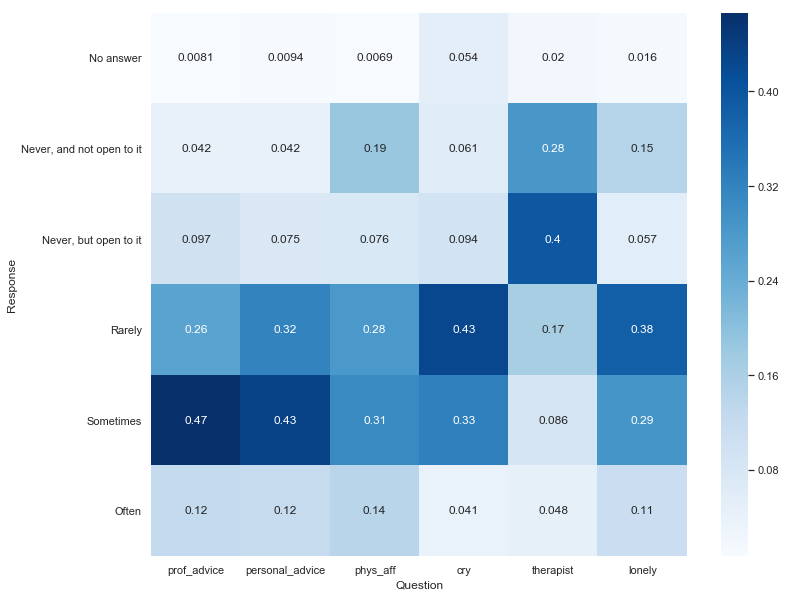

In [120]:
emo_cols = ['prof_advice', 'personal_advice', 'phys_aff', 'cry', 'therapist', 'lonely']

counts_df = pd.DataFrame()

for col in emo_cols:
    value_counts = responses[col].value_counts(sort = False)
    count_df = value_counts.rename_axis('Responses').to_frame(col)
    counts_df = pd.concat([counts_df, count_df], axis = 1)
    
counts_df = counts_df.reindex(['No answer', 'Never, and not open to it', 'Never, but open to it', 'Rarely', 'Sometimes', 'Often'])

counts_df_norm = counts_df.astype('float')/ counts_df.sum(axis=0).astype('float')
plt.figure(figsize=(12, 10))
ax = sns.heatmap(counts_df_norm, annot = True, cmap = 'Blues')
ax.set_ylabel('Response')
ax.set_xlabel('Question')

The responses to these questions sat on a graded scale, from 'Never' to 'Often', so I mapped them from 1-5. I decided NOT to exclude 'No answer' responses- it seemed like the lack of an answer was valuable as its own response. 'No answer was mapped ot 0.

In [121]:
for col in emo_cols:
    responses[col] = responses[col].map({'No answer': 0,
                                        'Never, and not open to it':1,
                                        'Never, but open to it':2,
                                        'Rarely':3,
                                        'Sometimes':4,
                                        'Often':5})

### Can the responses to questions about insecurities and emotional behaviors, plus the race, sexual orientation, age range, geographic region of the respondent predict how masculine they feel?

A little cleanup required:
- Race and Age range columns- no action needed
- In Orientation, mapped 13 'No Answer' values to 'Other'
- In Region, dropped rows with nan values (dropped 20 rows)

In [122]:
skips = responses['orientation.1'] == 'No answer'
responses.loc[skips, 'orientation.1'] = 'Other'
responses.dropna(subset =['region'], inplace = True)

### Get dummies for all

In [123]:
race_dummies = pd.get_dummies(responses['race'], prefix = 'race', drop_first = True)

In [124]:
orientation_dummies = pd.get_dummies(responses['orientation.1'], prefix = 'orientation', drop_first = True)

In [125]:
age_dummies = pd.get_dummies(responses['age3'], prefix = 'age', drop_first = True)

In [126]:
region_dummies = pd.get_dummies(responses['region'], prefix = 'region', drop_first = True)

### Set up X and y values

In [127]:
X = pd.concat([race_dummies, orientation_dummies, age_dummies, region_dummies, responses[worry_cols], responses[emo_cols]], axis = 'columns')
y = responses['self_manly']

In [128]:
X.shape

(1581, 34)

### Train-test split

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [130]:
X_train.shape

(1185, 34)

### Linear Regression
Can I use a linear regression for this classification problem?
Well, the output that I am trying to predict is numeric (0-3), but on a discrete scale (i.e. not continuous). So, I can use a regression to predict output on a continuous scale, but then set up threshold buckets to assign the output to one of my 4 classes.

In [131]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)

In [132]:
y_pred[1:20]

array([2.30090399, 2.34942516, 2.12614838, 1.72806682, 2.58600539,
       2.13643812, 1.95867586, 2.36251223, 2.04976565, 2.25297417,
       2.17189704, 2.48058831, 2.46941165, 2.31611396, 2.13347246,
       2.05588759, 2.3538415 , 2.54359673, 2.1318515 ])

In [133]:
y_pred = y_pred.round().astype(np.int)
y_pred[1:20]

array([2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2])

In [134]:
lin_accuracy = metrics.accuracy_score(y_pred, y_test)
lin_accuracy

0.4595959595959596

In [135]:
y_null = np.full(y_test.shape, 2)
null_accuracy = metrics.accuracy_score(y_null, y_test)
null_accuracy

0.44696969696969696

Hmmm.... that's not a very good accuracy score.

In [136]:
lin_precision = metrics.precision_score(y_pred, y_test, average = None)
lin_precision

array([0.        , 0.        , 0.91525424, 0.11494253])

In [137]:
lin_recall = metrics.recall_score(y_pred, y_test, average = None)
lin_recall

C:\Users\stephanie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


array([0.        , 0.        , 0.45      , 0.55555556])

In [138]:
lin_f1 = metrics.f1_score(y_pred, y_test, average = None)
lin_f1

C:\Users\stephanie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


array([0.        , 0.        , 0.60335196, 0.19047619])

So, we predicted about 53% of the test set correctly... which is theoretically better than a random guess- with 4 options, a random guess would be 25% accurate. However, we know that the responses are heavily skewed, with almost 90% of responses concentrated in either 2 or 3. So, we are dealing with a class imbalance problem, where the model performs more accurately by predicting the most commmon class.

What about precision score? (true positives/ total predicted positive)
<br>90% of predictions of 2 were correct- only 10% of responses that we predicted to be 2 were not actually 2.
<br>20% of predictions of 3 were correct. This means that 80% of the values that we predicted were 3 were not actually 3.

And recall? (true positives/ total actual positive)
<br>We only correctly classified 53% of true 2's, and correctly classified 54% of true 3's.

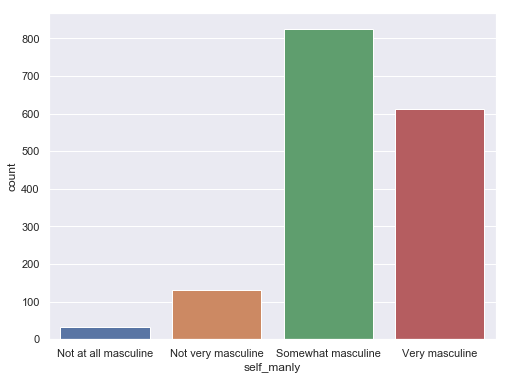

In [9]:
sns.set(style="darkgrid")
plt.figure(figsize=(8, 6))
ax = sns.countplot(x="self_manly", data=responses, order = ['Not at all masculine', 'Not very masculine', 'Somewhat masculine', 'Very masculine'])

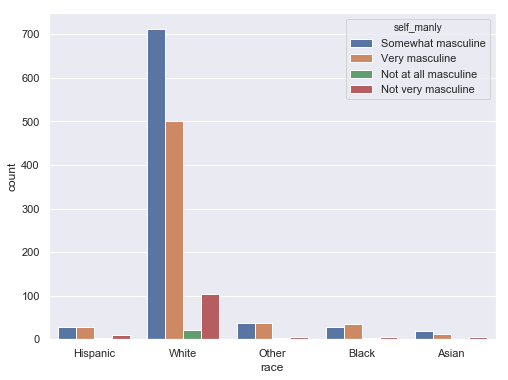

In [10]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x="race", hue="self_manly", data=responses)

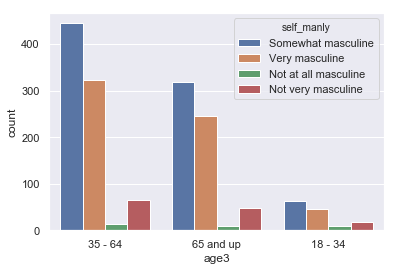

In [11]:
ax = sns.countplot(x="age3", hue="self_manly", data=responses)

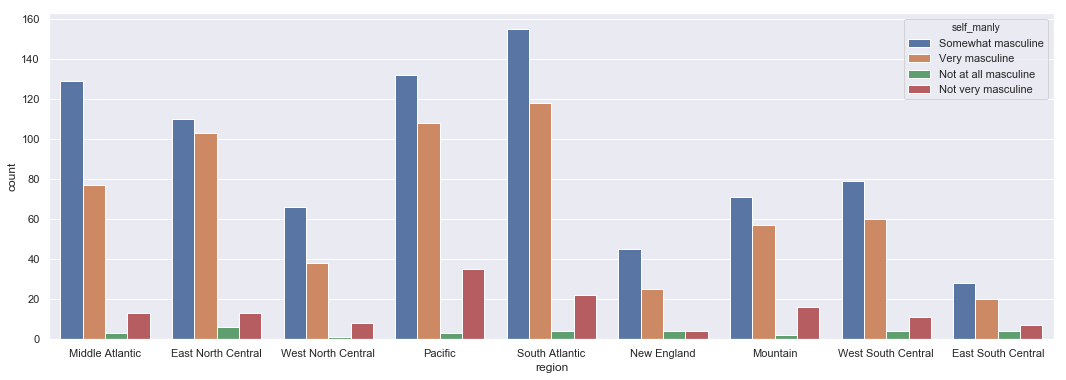

In [12]:
plt.figure(figsize=(18,6))
ax = sns.countplot(x="region", hue="self_manly", data=responses)

#### What if I try to balance the class imbalance using sample weights?

In [116]:
linreg = LinearRegression(normalize = True)

for i in range(len(y_train.value_counts())):
    sample_weights[sample_weights == i] = 1/y_train.value_counts().loc[i]
    
sample_weights = list(sample_weights)
linreg.fit(X_train, y_train, sample_weights)

y_pred = linreg.predict(X_test)

In [ ]:
weighted_lin_accuracy = metrics.accuracy_score(y_pred, y_test)
weighted_lin_accuracy

In [ ]:
lin_precision = metrics.precision_score(y_pred, y_test, average = None)
lin_precision

In [ ]:
lin_recall = metrics.recall_score(y_pred, y_test, average = None)
lin_recall

In [ ]:
lin_f1 = metrics.f1_score(y_pred, y_test, average = None)
lin_f1

### Linear Regression with PCA

In [139]:
from sklearn.decomposition import PCA
pca = PCA(svd_solver = 'full', n_components = .7)
X_train_trans = pca.fit_transform(X_train)
X_test_trans = pca.transform(X_test)

In [140]:
X_train_trans.shape

(1185, 6)

In [143]:
linreg = LinearRegression()
linreg.fit(X_train_trans, y_train)
y_pred = linreg.predict(X_test_trans)
y_pred = y_pred.round().astype(np.int)
lin_PCA_accuracy = metrics.accuracy_score(y_pred, y_test)
lin_PCA_accuracy

0.4696969696969697

In [144]:
lin_PCA_precision = metrics.precision_score(y_pred, y_test, average = None)
lin_PCA_precision

array([0.        , 0.        , 0.97175141, 0.08045977])

In [145]:
lin_PCA_recall = metrics.recall_score(y_pred, y_test, average = None)
lin_PCA_recall

C:\Users\stephanie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


array([0.        , 0.        , 0.45744681, 0.7       ])

In [146]:
lin_PCA_f1 = metrics.f1_score(y_pred, y_test, average = None)
lin_PCA_f1

C:\Users\stephanie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


array([0.        , 0.        , 0.62206148, 0.1443299 ])

### Logistic Regression

In [147]:
logreg = LogisticRegression()
logreg.fit(X_train_trans, y_train)
y_pred = logreg.predict(X_test_trans)
log_accuracy = metrics.accuracy_score(y_pred, y_test)
log_accuracy

0.4595959595959596

In [148]:
log_precision = metrics.precision_score(y_pred, y_test, average = None)
log_precision

array([0.        , 0.        , 0.81355932, 0.2183908 ])

In [149]:
log_recall = metrics.recall_score(y_pred, y_test, average = None)
log_recall

C:\Users\stephanie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


array([0.        , 0.        , 0.44859813, 0.50666667])

In [150]:
log_f1 = metrics.f1_score(y_pred, y_test, average = None)
log_f1

C:\Users\stephanie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


array([0.        , 0.        , 0.57831325, 0.30522088])

Text(0.5,12.5,'Predicted label')

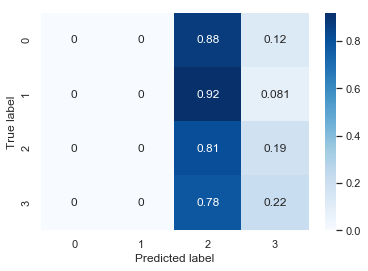

In [152]:
cm = metrics.confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
ax = sns.heatmap(cm, annot = True, cmap = 'Blues')
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')

0 = Not at all masculine
    1 = Not very masculine
    2 = Somewhat masculine
    3 = Very masculine

In [153]:
logreg = LogisticRegression(class_weight = 'balanced')

The class_weight = 'balanced' parameter uses the values of y to weight each value, inversely proportional to its frequency in the training data. Thus, common (frequent) values are weighted less, and less frequent values are weighted more. This helps to balance out the heavily skewed data.

In [154]:
logreg.fit(X_train_trans, y_train)
y_pred = logreg.predict(X_test_trans)
log_bal_accuracy = metrics.accuracy_score(y_pred, y_test)
log_bal_accuracy 

0.44696969696969696

In [155]:
log_bal_precision = metrics.precision_score(y_pred, y_test, average = None)
log_bal_precision

array([0.375     , 0.05405405, 0.69491525, 0.2816092 ])

In [156]:
log_bal_recall = metrics.recall_score(y_pred, y_test, average = None)
log_bal_recall

array([0.08571429, 0.5       , 0.45895522, 0.5505618 ])

In [157]:
log_bal_f1 = metrics.f1_score(y_pred, y_test, average = None)
log_bal_f1

array([0.13953488, 0.09756098, 0.55280899, 0.37262357])

### Cross Val Score

In [158]:
from sklearn.model_selection import cross_val_score

Using PCA transformed features:

In [159]:
pca = PCA(svd_solver = 'full', n_components = .7)
X_trans = pca.fit_transform(X)
cross_val_score(LogisticRegression(solver='lbfgs'), X_trans, y, cv=15).mean()

Using non-transformed features:

In [ ]:
cross_val_score(LogisticRegression(solver='lbfgs'), X, y, cv=15).mean()

### KNN

Using PCA transformed features:

In [162]:
scaler = StandardScaler()
X_train_trans = scaler.fit_transform(X_train_trans)
X_test_trans = scaler.transform(X_test_trans)
knn = KNeighborsClassifier() #use default n_neighbors = 5
knn.fit(X_train_trans, y_train)
y_pred = knn.predict(X_test_trans)
KNN_PCA_accuracy = metrics.accuracy_score(y_pred, y_test)
KNN_PCA_accuracy

0.43686868686868685

Using non-PCA transformed features:

In [69]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
knn = KNeighborsClassifier() #use default n_neighbors = 5
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
KNN_accuracy = metrics.accuracy_score(y_pred, y_test)
KNN_accuracy

0.49242424242424243

In [74]:
cm = metrics.confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
ax= sns.heatmap(cm, annot=True, cmap='Blues')
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')

Text(0.5,12.5,'Predicted label')

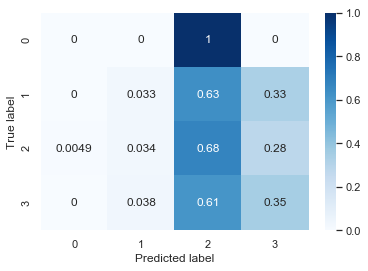

### Tuned KNN

In [76]:
knn = KNeighborsClassifier()

parameters = {'n_neighbors': range(1, 25),
             'weights': ['uniform', 'distance'],
             'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
             }

clf = GridSearchCV(knn, parameters, cv = 15, scoring='accuracy', verbose=1)

In [77]:
%%time
clf.fit(X_train, y_train)

Fitting 15 folds for each of 192 candidates, totalling 2880 fits
Wall time: 7min 13s


[Parallel(n_jobs=1)]: Done 2880 out of 2880 | elapsed:  7.2min finished


GridSearchCV(cv=15, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': range(1, 25), 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [80]:
clf.best_params_

{'algorithm': 'auto', 'n_neighbors': 24, 'weights': 'uniform'}

In [81]:
clf.best_score_

0.5215189873417722

In [82]:
y_pred = clf.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

Text(0.5,12.5,'Predicted label')

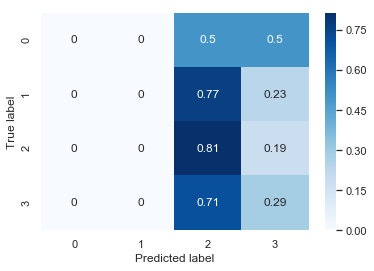

In [84]:
cm = metrics.confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
ax= sns.heatmap(cm, annot=True, cmap='Blues')
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')

In [85]:
y_test.value_counts()

2    205
3    157
1     30
0      4
Name: self_manly, dtype: int64

### Decision Tree
Decision Trees don't perform very well with unbalanced classes....

#### Comparing Scores

In [ ]:
#Accuracy Scores
accuracy_scores = ['lin_accuracy', 'null_accuracy', 'lin_PCA_accuracy', 'log_accuracy', 'log_bal_accuracy', 'KNN_PCA_accuracy', 'KNN_accuracy']

for score in accuracy_scores:
    print(score + ": {.2f}%".format(score * 100))

# Graveyard

In [ ]:
from sklearn.tree import DecisionTreeClassifier

treeclf = DecisionTreeClassifier()
parameters = {
    'max_depth': [None, 5, 10],
    'max_features': [None, 'auto'],
}

clf = GridSearchCV(treeclf, parameters, cv=5, scoring='accuracy', verbose=1)

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
clf.best_params_

In [ ]:
clf.best_score_

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
metrics.accuracy_score(y_test, y_pred)

### What if I drop the data from the insecurities and emotional behavior question? Do demographics predict anything?

In [ ]:
X = pd.concat([race_dummies, orientation_dummies, age_dummies, region_dummies], axis = 'columns')
y = responses['self_manly']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [ ]:
logreg = LogisticRegression()

In [ ]:
logreg.fit(X_train, y_train)

In [ ]:
y_pred = logreg.predict(X_test)

In [ ]:
metrics.accuracy_score(y_pred, y_test)

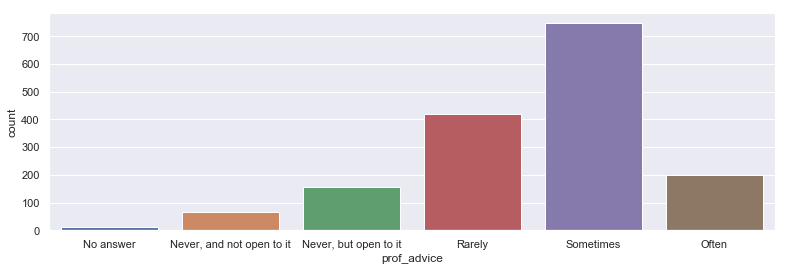

In [19]:
plt.figure(figsize=(13, 4))
ax = sns.countplot(x='prof_advice',  data=responses, order = ['No answer', 'Never, and not open to it', 'Never, but open to it', 'Rarely', 'Sometimes', 'Often'])

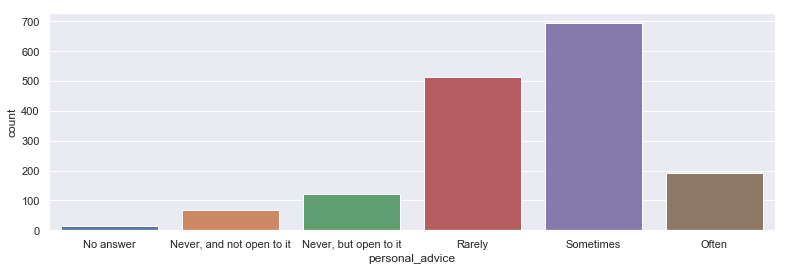

In [20]:
plt.figure(figsize=(13, 4))
ax = sns.countplot(x='personal_advice',  data=responses, order = ['No answer', 'Never, and not open to it', 'Never, but open to it', 'Rarely', 'Sometimes', 'Often'])

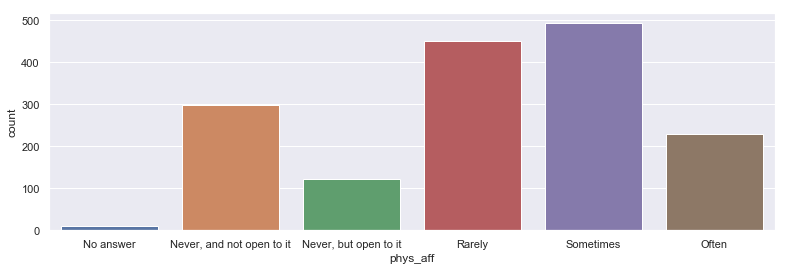

In [21]:
plt.figure(figsize=(13, 4))
ax = sns.countplot(x='phys_aff',  data=responses, order = ['No answer', 'Never, and not open to it', 'Never, but open to it', 'Rarely', 'Sometimes', 'Often'])

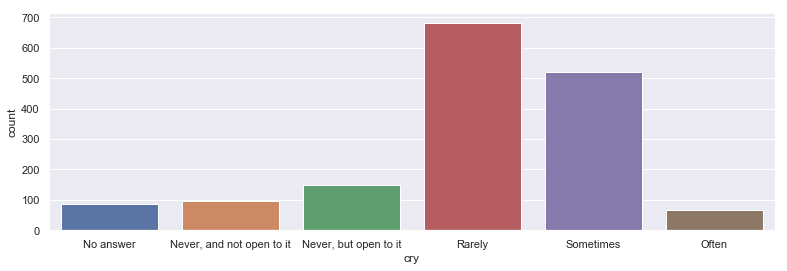

In [22]:
plt.figure(figsize=(13, 4))
ax_cry = sns.countplot(x='cry',  data=responses, order = ['No answer', 'Never, and not open to it', 'Never, but open to it', 'Rarely', 'Sometimes', 'Often'])

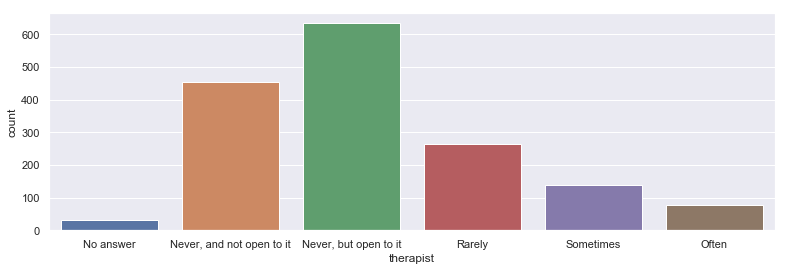

In [23]:
plt.figure(figsize=(13, 4))
ax_cry = sns.countplot(x='therapist',  data=responses, order = ['No answer', 'Never, and not open to it', 'Never, but open to it', 'Rarely', 'Sometimes', 'Often'])

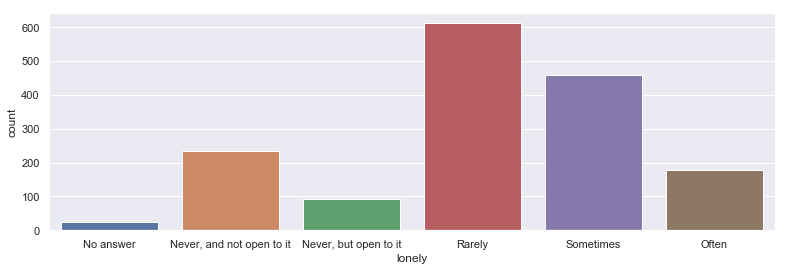

In [24]:
plt.figure(figsize=(13, 4))
ax_cry = sns.countplot(x = 'lonely', data=responses, order = ['No answer', 'Never, and not open to it', 'Never, but open to it', 'Rarely', 'Sometimes', 'Often'])

In [121]:
max(sample_weights)

0.037037037037037035

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [123]:
y_pred = linreg.predict(X_test)

In [124]:
y_pred = y_pred.round().astype(np.int)

In [125]:
metrics.accuracy_score(y_pred, y_test)

0.4898989898989899

In [126]:
print('Coefficients: \n', linreg.coef_ )

Coefficients: 
 [ 0.26562765 -0.12392385  0.10509856  0.06812205  0.11892246  0.3347572
  0.14906607  0.16252816 -0.03943755 -0.02644903 -0.04257917 -0.32680771
 -0.14623095 -0.00628497 -0.11786504 -0.18547569  0.08894533  0.05069269
  0.04855356 -0.10373225 -0.1380032  -0.02448057 -0.01620235 -0.1396606
 -0.07123955 -0.05196189  0.05916933 -0.09303465  0.05304091 -0.0085402
  0.05552996  0.00749226  0.02694917 -0.12559999]


In [127]:
print('Mean squared error: %.2f' % metrics.mean_squared_error(y_test, y_pred))

Mean squared error: 0.62


In [128]:
print('Variance: %.2f' % metrics.r2_score(y_test, y_pred))

Variance: -0.24
